In [1]:
import os
import pandas as pd, numpy as np
from glob import glob
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns 

from PIL import Image
import cv2

import warnings
warnings.filterwarnings('ignore')

### NIH Data

In [2]:
df_bbox = pd.read_csv('/kaggle/input/data/BBox_List_2017.csv')
df_bbox = df_bbox.drop(columns=df_bbox.columns[-3:].tolist())
df_bbox.rename(columns={'Bbox [x': 'x', 'h]': 'h'}, inplace=True)
df_bbox

,Image Index,Finding Label,x,y,w,h
0,00013118_008.png,Atelectasis,225.084746,547.019217,86.779661,79.186441
1,00014716_007.png,Atelectasis,686.101695,131.543498,185.491525,313.491525
2,00029817_009.png,Atelectasis,221.830508,317.053115,155.118644,216.949153
3,00014687_001.png,Atelectasis,726.237288,494.951420,141.016949,55.322034
4,00017877_001.png,Atelectasis,660.067797,569.780787,200.677966,78.101695
...,...,...,...,...,...,...
979,00029464_015.png,Atelectasis,198.940451,352.900747,615.537778,323.128889
980,00025769_001.png,Atelectasis,701.838229,572.491858,103.537778,63.715556
981,00016837_002.png,Atelectasis,140.913785,658.962969,271.928889,94.435556
982,00020124_003.png,Atelectasis,175.047118,580.456302,244.622222,103.537778


In [3]:
df_bbox['height'] = 1024
df_bbox['width'] = 1024

In [4]:
df_bbox = df_bbox[df_bbox['Finding Label'].isin(['Cardiomegaly','Effusion','Atelectasis'])]

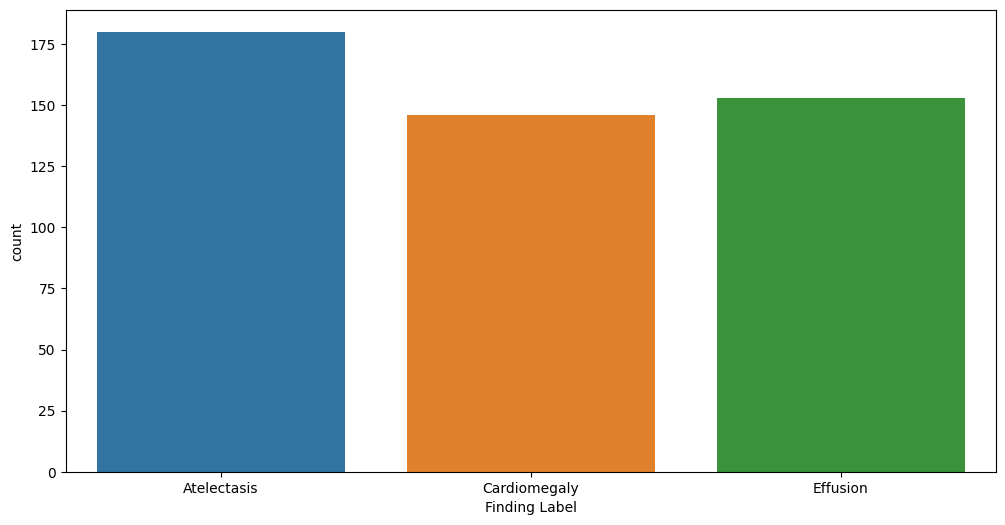

In [5]:
plt.figure(figsize=(12,6))

sns.countplot(x=df_bbox['Finding Label'])

plt.show()

In [6]:
mapping_path = {os.path.basename(x): x for x in glob('../input/data/*/images/*.png')}

df_bbox['path'] = df_bbox['Image Index'].map(mapping_path)

### VinBigData

In [7]:
PATH = '/kaggle/input/vinbigdata-original-image-dataset/vinbigdata/'

df_vin = pd.read_csv(PATH+'train.csv')
df_vin = df_vin.sort_values(by='image_id').reset_index(drop=True)

In [8]:
df_vin = df_vin[df_vin['class_name'].isin(['Atelectasis','Pleural effusion','Cardiomegaly'])]
df_vin['class_name'] = df_vin['class_name'].replace('Pleural effusion', 'Effusion')
df_vin = df_vin.reset_index(drop=True)
print('Shape of DataFrame: ', df_vin.shape)
print(display(df_vin))

Shape of DataFrame:  (8182, 10)


,image_id,class_name,class_id,rad_id,x_min,y_min,x_max,y_max,width,height
0,0007d316f756b3fa0baea2ff514ce945,Cardiomegaly,3,R10,902.0,1827.0,1829.0,2037.0,2304,2880
1,00150343289f317a0ad5629d5b7d9ef9,Effusion,10,R10,1876.0,1103.0,2239.0,1334.0,2525,2508
2,00150343289f317a0ad5629d5b7d9ef9,Effusion,10,R8,254.0,1261.0,402.0,1434.0,2525,2508
3,00150343289f317a0ad5629d5b7d9ef9,Effusion,10,R8,2054.0,1112.0,2282.0,1329.0,2525,2508
4,00150343289f317a0ad5629d5b7d9ef9,Cardiomegaly,3,R8,818.0,1053.0,1913.0,1340.0,2525,2508
...,...,...,...,...,...,...,...,...,...,...
8177,ffceb71a80efba3b83c88e11f4b9694b,Cardiomegaly,3,R11,570.0,1108.0,1973.0,2016.0,2109,2344
8178,ffceb71a80efba3b83c88e11f4b9694b,Cardiomegaly,3,R13,579.0,1074.0,1920.0,1771.0,2109,2344
8179,ffe6f9fe648a7ec29a50feb92d6c15a4,Cardiomegaly,3,R9,1144.0,1851.0,2297.0,2384.0,2685,2857
8180,ffe6f9fe648a7ec29a50feb92d6c15a4,Cardiomegaly,3,R8,1156.0,1789.0,2315.0,2360.0,2685,2857


None


In [9]:
mapping_path = {os.path.basename(x).split('.')[0]: x for x in glob('../input/*/vinbigdata/train/*.jpg')}

df_vin['path'] = df_vin['image_id'].map(mapping_path)

In [10]:
df_vin = df_vin.groupby(['image_id','class_name']).agg('first').reset_index()

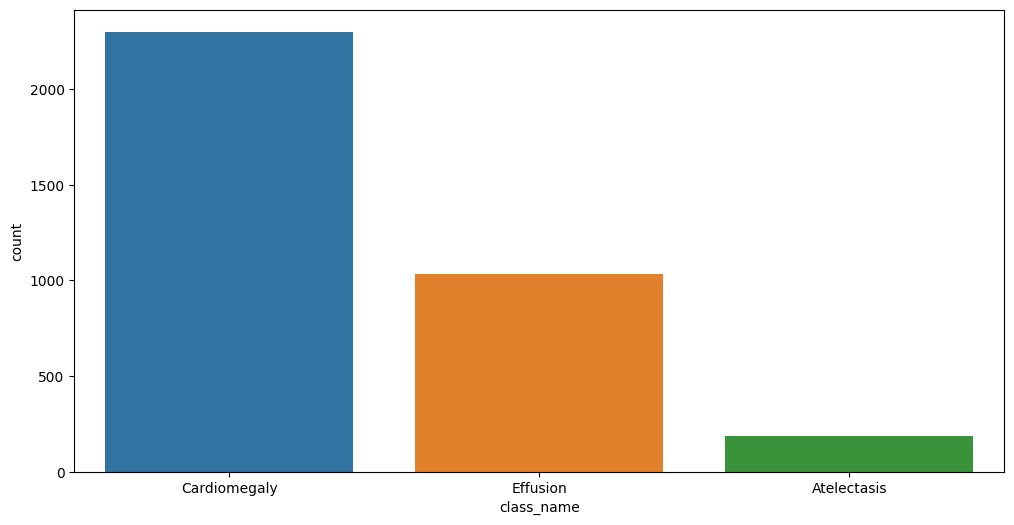

In [11]:
plt.figure(figsize=(12,6))

sns.countplot(x=df_vin['class_name'])

plt.show()

In [12]:
df_vin['h'] = df_vin['y_max'] - df_vin['y_min']
df_vin['w'] = df_vin['x_max'] - df_vin['x_min']

df_vin = df_vin.rename(columns={'image_id':'Image Index','class_name':'Finding Label','x_min':'x','y_min':'y'})
df_vin = df_vin.drop(columns=['class_id','rad_id', 'x_max','y_max'])

In [13]:
vin_1 = df_vin[df_vin['Finding Label'] == 'Effusion'].sample(347, random_state=42)
vin_2 = df_vin[df_vin['Finding Label'] == 'Cardiomegaly'].sample(354, random_state=42)
vin_3 = df_vin[df_vin['Finding Label'] == 'Atelectasis']

df_vin = pd.concat([vin_1,vin_2,vin_3], axis=0).reset_index(drop=True)

In [14]:
df = pd.concat([df_bbox, df_vin], axis=0).reset_index(drop=True)

In [15]:
df['Finding Label'].value_counts()

Finding Label
Cardiomegaly    500
Effusion        500
Atelectasis     366
Name: count, dtype: int64

In [16]:
import shutil

In [17]:
df.to_csv('metadata.csv', index=False)

In [18]:
df = df.drop_duplicates(subset=['Image Index'])

In [19]:
PATH = '/kaggle/working/lung_diseases/'

for label in df['Finding Label'].unique():
    os.makedirs(os.path.join(PATH,label), exist_ok=True)
    
    tmp = df[df['Finding Label'] == label]
    tmp = tmp.drop_duplicates(subset=['Image Index']).reset_index(drop=True)
    
    for file in tqdm(tmp['path'].unique()):
        shutil.copy(file, os.path.join(PATH,label))

100%|██████████| 485/485 [00:12<00:00, 38.86it/s]
